In [2]:
import torch
from torch.functional import F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
import copy
import numpy as np
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

from sad_nns.uncertainty import *
from neurops import *

/home/gottlijd/senior-research/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


**NORTH:** Define a LeNet-style model. 

Use the `ModSequential` class to wrap the `ModConv2d` and `ModLinear` model, which allows us to mask, prune, and grow the model. 

Use the `track_activations` and `track_auxiliary_gradients` arguments to enable the tracking of activations and auxiliary gradients later. 

By adding the `input_shape` of the data, we can compute the conversion factor of how many input neurons to add to the first linear layer when a new output channel is added to the final convolutional layer. 

In [4]:
# set seed
torch.manual_seed(0)

In [5]:
model = ModSequential(
        ModConv2d(in_channels=1, out_channels=8, kernel_size=7, masked=True, padding=1, learnable_mask=True),
        ModConv2d(in_channels=8, out_channels=16, kernel_size=7, masked=True, padding=1, prebatchnorm=True, learnable_mask=True),
        ModConv2d(in_channels=16, out_channels=16, kernel_size=5, masked=True, prebatchnorm=True, learnable_mask=True),
        ModLinear(64, 32, masked=True, prebatchnorm=True, learnable_mask=True),
        ModLinear(32, 10, masked=True, prebatchnorm=True, nonlinearity=""),
        track_activations=True,
        track_auxiliary_gradients=True,
        input_shape = (1, 14, 14)
    ).to(device)
torch.compile(model)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

# Add EDL Loss Function
# KLDivergenceLoss, MaximumLikelihoodLoss, CrossEntropyBayesRisk, SquaredErrorBayesRisk
criterion = SquaredErrorBayesRisk()
kl_divergence = KLDivergenceLoss()

**NORTH:** Get a dataset and define standard training and testing functions.

In [6]:
dataset = datasets.MNIST('../data', train=True, download=True,
                     transform=transforms.Compose([ 
                            transforms.ToTensor(),
                            transforms.Normalize((0.1307,), (0.3081,)),
                            transforms.Resize((14,14))
                        ]))
train_set, val_set = torch.utils.data.random_split(dataset, lengths=[int(0.9*len(dataset)), int(0.1*len(dataset))])
train_loader = torch.utils.data.DataLoader(train_set, batch_size=128, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=128, shuffle=True)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                            transforms.ToTensor(),
                            transforms.Normalize((0.1307,), (0.3081,)),
                            transforms.Resize((14,14))
                        ])),
    batch_size=128, shuffle=True)

def train(model, train_loader, optimizer, criterion, epochs=10, num_classes=10, val_loader=None, verbose=True, plot=False, return_vals=False):
    model.train()

    train_acc_vals = []
    train_u_vals = []
    test_acc_vals = []
    test_u_vals = []

    for epoch in range(epochs):
        correct = 0
        for batch_idx, (data, target) in enumerate(train_loader):

            data, target = data.to(device), target.to(device)
            one_hot_target = F.one_hot(target, num_classes=num_classes)
            optimizer.zero_grad()
            output = model(data)
            
            pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

            # calculate uncertainty
            evidence = F.relu(output)
            alpha = evidence + 1
            u = num_classes / torch.sum(alpha, dim=1, keepdim=True)

            loss = criterion(evidence, one_hot_target)

            # calculate KL Divergence
            kl_div_loss = kl_divergence(evidence, one_hot_target)
            annealing_step = 10
            annealing_coef = torch.min(
                torch.tensor(1.0, dtype=torch.float32),
                torch.tensor(epoch / annealing_step, dtype=torch.float32),
            )
            
            loss = loss + annealing_coef * kl_div_loss

            loss.backward()
            optimizer.step()
            if batch_idx % 100 == 0 and verbose:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\tUncertainty: {:.6f}'.format(
                    epoch, batch_idx * len(data), len(train_loader.dataset),
                    100. * batch_idx / len(train_loader), loss.item(), u.mean()))
                
        train_acc, train_u = correct / len(train_loader.dataset), u.mean().detach().numpy().item()
        train_acc_vals.append(train_acc)
        train_u_vals.append(train_u)
        
        if val_loader is not None:
            print("Validation: ", end = "")
            test_acc, test_u = test(model, val_loader, criterion, return_vals=True)
            test_acc_vals.append(test_acc)
            test_u_vals.append(test_u)

    if plot:
        # Plotting the lines
        plt.plot(np.arange(epochs), train_acc_vals, label='Training Accuracy', color='blue')
        plt.plot(np.arange(epochs), train_u_vals, label='Training Uncertainty', color='purple')
        plt.plot(np.arange(epochs), test_acc_vals, label='Testing Accuracy', color='orange')
        plt.plot(np.arange(epochs), test_u_vals, label='Testing Uncertainty', color='red')
        plt.xticks(np.arange(0, epochs, 1))

        # Adding titles and labels
        plt.title('Accuracy vs. Uncertainty')
        plt.xlabel('Epoch')
        plt.ylabel('Value')
        plt.legend()

        # Show the plot
        plt.show()
    elif return_vals:
        return train_acc, train_u, test_acc, test_u

def test(model, test_loader, criterion, num_classes=10, return_vals=False):
    model.eval()
    test_loss = 0
    correct = 0
    uncertainties = []

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            one_hot_target = F.one_hot(target, num_classes=num_classes)
            output = model(data)

            evidence = F.relu(output)
            alpha = evidence + 1
            u = num_classes / torch.sum(alpha, dim=1, keepdim=True)
            uncertainties.append(u.mean())

            # test_loss += criterion(output, target).item() # sum up batch loss
            test_loss += criterion(output, one_hot_target).item()
            pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    avg_u = np.mean(uncertainties)
    
    print('Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%), Average Uncertainty: {:.4f}'.format(test_loss, correct, len(test_loader.dataset),
        accuracy, avg_u))
    
    if return_vals:
        return accuracy / 100, avg_u

**NORTH:** Pretrain the model before changing the architecture

/home/gottlijd/senior-research/.venv/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Train Epoch: 0 [0/54000 (0%)]	Loss: 0.981221	Uncertainty: 0.845094
Train Epoch: 0 [12800/54000 (24%)]	Loss: 0.861000	Uncertainty: 0.812008
Train Epoch: 0 [25600/54000 (47%)]	Loss: 0.830189	Uncertainty: 0.790378
Train Epoch: 0 [38400/54000 (71%)]	Loss: 0.784861	Uncertainty: 0.769037
Train Epoch: 0 [51200/54000 (95%)]	Loss: 0.762360	Uncertainty: 0.757058
Validation: Average loss: 0.0052, Accuracy: 4795/6000 (79.92%), Average Uncertainty: 0.7474
Train Epoch: 1 [0/54000 (0%)]	Loss: 0.784085	Uncertainty: 0.744701
Train Epoch: 1 [12800/54000 (24%)]	Loss: 0.640786	Uncertainty: 0.622684
Train Epoch: 1 [25600/54000 (47%)]	Loss: 0.444347	Uncertainty: 0.550568
Train Epoch: 1 [38400/54000 (71%)]	Loss: 0.335802	Uncertainty: 0.464248
Train Epoch: 1 [51200/54000 (95%)]	Loss: 0.359896	Uncertainty: 0.409669
Validation: Average loss: 0.0164, Accuracy: 5375/6000 (89.58%), Average Uncertainty: 0.3959


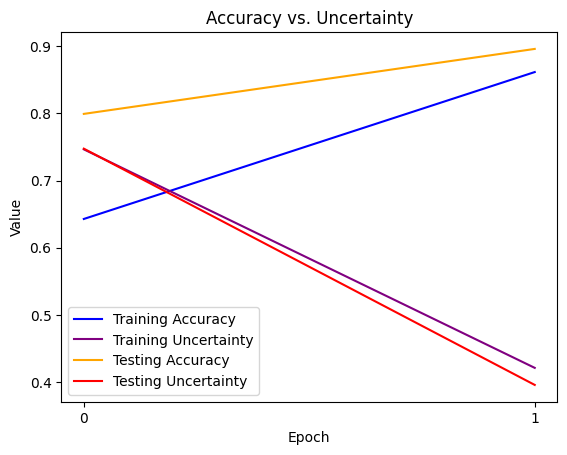

In [7]:
train(model, train_loader, optimizer, criterion, epochs=2, val_loader=val_loader, plot=True)

/home/gottlijd/senior-research/.venv/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Average loss: 0.0136, Accuracy: 5414/6000 (90.23%), Average Uncertainty: 0.3926
Train Epoch: 0 [0/54000 (0%)]	Loss: 0.726496	Uncertainty: 0.748009
Train Epoch: 0 [12800/54000 (24%)]	Loss: 0.682183	Uncertainty: 0.723842
Train Epoch: 0 [25600/54000 (47%)]	Loss: 0.652617	Uncertainty: 0.710171
Train Epoch: 0 [38400/54000 (71%)]	Loss: 0.642586	Uncertainty: 0.697965
Train Epoch: 0 [51200/54000 (95%)]	Loss: 0.617621	Uncertainty: 0.687874
Validation: Average loss: 0.0037, Accuracy: 5422/6000 (90.37%), Average Uncertainty: 0.6883
Train Epoch: 1 [0/54000 (0%)]	Loss: 0.623869	Uncertainty: 0.684042
Train Epoch: 1 [12800/54000 (24%)]	Loss: 0.489922	Uncertainty: 0.563655
Train Epoch: 1 [25600/54000 (47%)]	Loss: 0.364271	Uncertainty: 0.492041
Train Epoch: 1 [38400/54000 (71%)]	Loss: 0.337813	Uncertainty: 0.451672
Train Epoch: 1 [51200/54000 (95%)]	Loss: 0.303186	Uncertainty: 0.399695
Validation: Average loss: 0.0079, Accuracy: 5496/6000 (91.60%), Average Uncertainty: 0.4142
Train Epoch: 2 [0/54000 (0

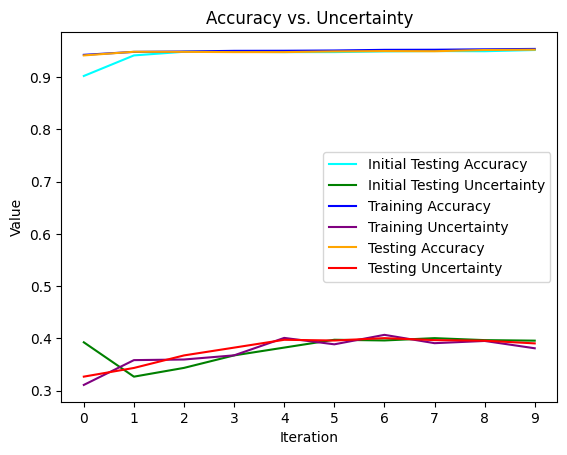

In [24]:
iterations = 10
modded_model = copy.deepcopy(model)
modded_optimizer = torch.optim.SGD(modded_model.parameters(), lr=0.01)
modded_optimizer.load_state_dict(optimizer.state_dict())

init_test_acc_vals = []
init_test_u_vals = []
train_acc_vals = []
train_u_vals = []
test_acc_vals = []
test_u_vals = []

for iter in range(iterations):
    init_test_acc, init_test_u = test(modded_model, val_loader, criterion, return_vals=True)
    train_acc, train_u, test_acc, test_u = train(modded_model, train_loader, modded_optimizer, criterion, epochs=5, val_loader=val_loader, return_vals=True)

    init_test_acc_vals.append(init_test_acc)
    init_test_u_vals.append(init_test_u)
    train_acc_vals.append(train_acc)
    train_u_vals.append(train_u)
    test_acc_vals.append(test_acc)
    test_u_vals.append(test_u)

# Plotting the lines
plt.plot(np.arange(iterations), init_test_acc_vals, label='Initial Testing Accuracy', color='cyan')
plt.plot(np.arange(iterations), init_test_u_vals, label='Initial Testing Uncertainty', color='green')
plt.plot(np.arange(iterations), train_acc_vals, label='Training Accuracy', color='blue')
plt.plot(np.arange(iterations), train_u_vals, label='Training Uncertainty', color='purple')
plt.plot(np.arange(iterations), test_acc_vals, label='Testing Accuracy', color='orange')
plt.plot(np.arange(iterations), test_u_vals, label='Testing Uncertainty', color='red')
plt.xticks(np.arange(0, iterations, 1))

# Adding titles and labels
plt.title('Accuracy vs. Uncertainty')
plt.xlabel('Iteration')
plt.ylabel('Value')
plt.legend()

# Show the plot
plt.show()

### **NORTH:** Model Optimization Techniques

**NORTH:** Use a heuristic from `metrics.py` to measure the existing channels and neurons to determine which ones to prune.

The simplest one is measuring the norm of incoming weights to a neuron. We'll copy the model (so we have access to the original), then score each neuron and prune the lowest scoring ones within each layer. After running the following block, try uncommenting different lines to see how different metrics affect the model.

In [67]:
iterations = 4
modded_model = copy.deepcopy(model)
modded_optimizer = torch.optim.SGD(modded_model.parameters(), lr=0.01)
modded_optimizer.load_state_dict(optimizer.state_dict())

for iter in range(iterations):
    init_test_acc, init_test_u = test(modded_model, val_loader, criterion, return_vals=True)
    train_acc, train_u, test_acc, test_u = train(modded_model, train_loader, modded_optimizer, criterion, epochs=1, val_loader=val_loader, return_vals=True)

    print('-----------------------------------------')
    print(f'# activation layers: {len(modded_model.activations)}')
    print(modded_model.parameter_count())
    for layer in range(len(modded_model.activations)):
        print(modded_model.activations[str(layer)].shape)
        
    print('-----------------------------------------')


/home/gottlijd/senior-research/.venv/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Average loss: 0.0136, Accuracy: 5414/6000 (90.23%), Average Uncertainty: 0.3927
Train Epoch: 0 [0/54000 (0%)]	Loss: 0.725979	Uncertainty: 0.749096
Train Epoch: 0 [12800/54000 (24%)]	Loss: 0.664215	Uncertainty: 0.724131
Train Epoch: 0 [25600/54000 (47%)]	Loss: 0.638456	Uncertainty: 0.710735
Train Epoch: 0 [38400/54000 (71%)]	Loss: 0.647478	Uncertainty: 0.702407
Train Epoch: 0 [51200/54000 (95%)]	Loss: 0.605382	Uncertainty: 0.691101
Validation: Average loss: 0.0037, Accuracy: 5414/6000 (90.23%), Average Uncertainty: 0.6900
-----------------------------------------
# activation layers: 7
15754
torch.Size([16, 8, 10, 10])
torch.Size([32, 16, 6, 6])
torch.Size([32, 16, 2, 2])
torch.Size([64, 32])
torch.Size([20, 10])
torch.Size([0])
torch.Size([0])
-----------------------------------------
Average loss: 0.0037, Accuracy: 5414/6000 (90.23%), Average Uncertainty: 0.6900
Train Epoch: 0 [0/54000 (0%)]	Loss: 0.615498	Uncertainty: 0.689914
Train Epoch: 0 [12800/54000 (24%)]	Loss: 0.606627	Uncerta

Layer 0 scores: mean 3.99, std 0.248, min 3.64, smallest 25%: [4 6]
Layer 1 scores: mean 7.88, std 0.295, min 7.29, smallest 25%: [ 6  4 11  7]
Layer 2 scores: mean 7.97, std 0.249, min 7.6, smallest 25%: [ 0  3  4 11]
Layer 3 scores: mean 3.16, std 0.265, min 2.62, smallest 25%: [25 24  6 30  2  7 12 14]
The pruned model has 9058 effective parameters.
Validation after pruning: Average loss: -0.0185, Accuracy: 4337/6000 (72.28%), Average Uncertainty: 0.6262
Train Epoch: 0 [0/54000 (0%)]	Loss: 0.801152	Uncertainty: 0.787639
Train Epoch: 0 [12800/54000 (24%)]	Loss: 0.746596	Uncertainty: 0.762351
Train Epoch: 0 [25600/54000 (47%)]	Loss: 0.724510	Uncertainty: 0.750196
Train Epoch: 0 [38400/54000 (71%)]	Loss: 0.704877	Uncertainty: 0.739250
Train Epoch: 0 [51200/54000 (95%)]	Loss: 0.670152	Uncertainty: 0.725504
Validation: Average loss: 0.0043, Accuracy: 5323/6000 (88.72%), Average Uncertainty: 0.7238
Train Epoch: 1 [0/54000 (0%)]	Loss: 0.707394	Uncertainty: 0.721820
Train Epoch: 1 [12800/54

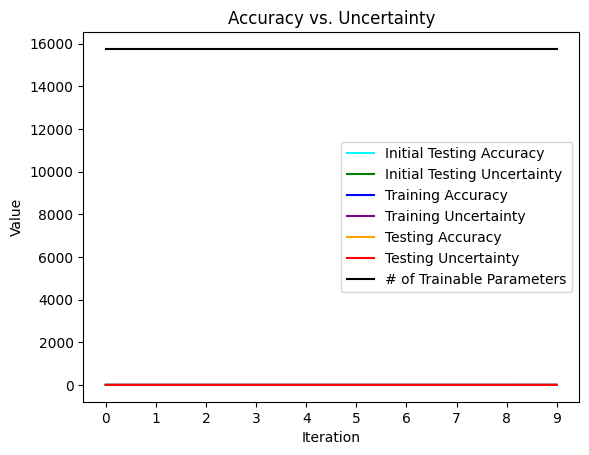

In [8]:
iterations = 10
modded_model = copy.deepcopy(model)
modded_optimizer = torch.optim.SGD(modded_model.parameters(), lr=0.01)
modded_optimizer.load_state_dict(optimizer.state_dict())

init_test_acc_vals = []
init_test_u_vals = []
train_acc_vals = []
train_u_vals = []
test_acc_vals = []
test_u_vals = []
param_count_vals = []

for iter in range(iterations):
    for i in range(len(model)-1):
        scores = weight_sum(modded_model[i].weight)
        # scores = weight_sum(modded_model[i].weight) +  weight_sum(modded_model[i+1].weight, fanin=False, conversion_factor=model.conversion_factor if i == model.conversion_layer else -1)
        # scores = activation_variance(modded_model.activations[str(i)])

        # print('-----------------------------------------')
        # print(f'# activation layers: {len(modded_model.activations)}')
        # print(modded_model.parameter_count())
        # for layer in range(len(modded_model.activations)):
        #     print(modded_model.activations[str(layer)].shape)
        
        # print('-----------------------------------------')

        # scores = svd_score(modded_model.activations[str(i*2)])
        # scores = nuclear_score(modded_model.activations[str(i)], average=i<3)
        # scores = modded_model[i+1].batchnorm.weight.abs() if i != modded_model.conversion_layer else modded_model[i+1].batchnorm.weight.abs().reshape(modded_model.conversion_factor,-1).sum(0) 
        # Before trying this line, run the following block: # scores = fisher_info(mask_grads[i])
        print("Layer {} scores: mean {:.3g}, std {:.3g}, min {:.3g}, smallest 25%:".format(i, scores.mean(), scores.std(), scores.min()), end=" ")
        to_prune = np.argsort(scores.detach().cpu().numpy())[:int(0.25*len(scores))]
        print(to_prune)
        modded_model.prune(i, to_prune, optimizer=modded_optimizer, clear_activations=True)
    
    print("The pruned model has {} effective parameters.".format(modded_model.parameter_count(masked = True)))
    print("Validation after pruning: ", end = "")
    init_test_acc, init_test_u = test(modded_model, val_loader, criterion, verbose=False, return_vals=True)
    train_acc, train_u, test_acc, test_u = train(modded_model, train_loader, modded_optimizer, criterion, epochs=5, val_loader=val_loader, verbose=False, return_vals=True)

    init_test_acc_vals.append(init_test_acc)
    init_test_u_vals.append(init_test_u)
    train_acc_vals.append(train_acc)
    train_u_vals.append(train_u)
    test_acc_vals.append(test_acc)
    test_u_vals.append(test_u)
    print(f'Total Effective Parameters{model.parameter_count()})

# Plotting the lines
plt.plot(np.arange(iterations), init_test_acc_vals, label='Initial Testing Accuracy', color='cyan')
plt.plot(np.arange(iterations), init_test_u_vals, label='Initial Testing Uncertainty', color='green')
plt.plot(np.arange(iterations), train_acc_vals, label='Training Accuracy', color='blue')
plt.plot(np.arange(iterations), train_u_vals, label='Training Uncertainty', color='purple')
plt.plot(np.arange(iterations), test_acc_vals, label='Testing Accuracy', color='orange')
plt.plot(np.arange(iterations), test_u_vals, label='Testing Uncertainty', color='red')
plt.xticks(np.arange(0, iterations, 1))

# Adding titles and labels
plt.title('Accuracy vs. Uncertainty')
plt.xlabel('Iteration')
plt.ylabel('Value')
plt.legend()

# Show the plot
plt.show()

**NORTH:** Grow the model using a neurogenesis strategy similar to NORTH-Random.

In [9]:
iterations = 10
modded_model_grow = copy.deepcopy(model)
modded_optimizer_grow = torch.optim.SGD(modded_model_grow.parameters(), lr=0.01)
modded_optimizer_grow.load_state_dict(optimizer.state_dict())

init_test_acc_vals = []
init_test_u_vals = []
train_acc_vals = []
train_u_vals = []
test_acc_vals = []
test_u_vals = []
param_count_vals = []

for iter in range(iterations):
    for i in range(len(model)-1):
        #score = orthogonality_gap(modded_model_grow.activations[str(i)])
        max_rank = modded_model_grow[i].width()
        score = effective_rank(modded_model_grow.activations[str(i)])
        to_add = max(score-int(0.95*max_rank), 0)
        print("Layer {} score: {}/{}, neurons to add: {}".format(i, score, max_rank, to_add))
        modded_model_grow.grow(i, to_add, fanin_weights="iterative_orthogonalization",
                               optimizer=modded_optimizer_grow)
    print("The grown model now has {} effective parameters.".format(modded_model_grow.parameter_count(masked = True)))
    print("Validation after growing: ", end = "")
    init_test_acc, init_test_u = test(modded_model_grow, val_loader, criterion, return_vals=True)
    train_acc, train_u, test_acc, test_u = train(modded_model_grow, train_loader, modded_optimizer, criterion, epochs=5, val_loader=val_loader, return_vals=True)

    init_test_acc_vals.append(init_test_acc)
    init_test_u_vals.append(init_test_u)
    train_acc_vals.append(train_acc)
    train_u_vals.append(train_u)
    test_acc_vals.append(test_acc)
    test_u_vals.append(test_u)
    param_count_vals.append(model.parameter_count())

# Plotting the lines
plt.plot(np.arange(iterations), init_test_acc_vals, label='Initial Testing Accuracy', color='cyan')
plt.plot(np.arange(iterations), init_test_u_vals, label='Initial Testing Uncertainty', color='green')
plt.plot(np.arange(iterations), train_acc_vals, label='Training Accuracy', color='blue')
plt.plot(np.arange(iterations), train_u_vals, label='Training Uncertainty', color='purple')
plt.plot(np.arange(iterations), test_acc_vals, label='Testing Accuracy', color='orange')
plt.plot(np.arange(iterations), test_u_vals, label='Testing Uncertainty', color='red')
plt.plot(np.arange(iterations), param_count_vals, label='# of Trainable Parameters', color='black')
plt.xticks(np.arange(0, iterations, 1))

# Adding titles and labels
plt.title('Accuracy vs. Uncertainty')
plt.xlabel('Iteration')
plt.ylabel('Value')
plt.legend()

# Show the plot
plt.show()

Layer 0 score: 8/8, neurons to add: 1
Layer 1 score: 16/16, neurons to add: 1
Layer 2 score: 16/16, neurons to add: 1
Layer 3 score: 32/32, neurons to add: 2
The grown model now has 16731 effective parameters.
Validation after growing: Average loss: 0.0164, Accuracy: 5375/6000 (89.58%), Average Uncertainty: 0.3959
Train Epoch: 0 [0/54000 (0%)]	Loss: 0.736513	Uncertainty: 0.753709
Train Epoch: 0 [12800/54000 (24%)]	Loss: 0.728863	Uncertainty: 0.751498
Train Epoch: 0 [25600/54000 (47%)]	Loss: 0.708313	Uncertainty: 0.753709
Train Epoch: 0 [38400/54000 (71%)]	Loss: 0.719870	Uncertainty: 0.751508
Train Epoch: 0 [51200/54000 (95%)]	Loss: 0.721145	Uncertainty: 0.751601
Validation: Average loss: 0.0075, Accuracy: 5132/6000 (85.53%), Average Uncertainty: 0.7516
Train Epoch: 1 [0/54000 (0%)]	Loss: 0.730014	Uncertainty: 0.743852
Train Epoch: 1 [12800/54000 (24%)]	Loss: 0.767510	Uncertainty: 0.756355
Train Epoch: 1 [25600/54000 (47%)]	Loss: 0.747193	Uncertainty: 0.748151
Train Epoch: 1 [38400/5400